* [Excercise 5.8. Racetrack](#Excercise-5.8.-Racetrack)

## Excercise 5.8. Racetrack

In [37]:
from collections import namedtuple, defaultdict
import random
import numpy as np
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt

### Define Racetracks

Track definitions were copied from https://github.com/jkillingsworth/ReinforcementLearning/blob/master/chapter05/Racetrack/Track.fs

In [2]:
MAX_SPEED = 4
N_ACTIONS = 3  # number of actions along x and y: 0, 1, -1

In [3]:
track1 = """
                  
   XXXXXXXXXXXXXF 
  XXXXXXXXXXXXXXF 
  XXXXXXXXXXXXXXF 
 XXXXXXXXXXXXXXXF 
XXXXXXXXXXXXXXXXF 
XXXXXXXXXXXXXXXXF 
XXXXXXXXXX        
XXXXXXXXX         
XXXXXXXXX         
XXXXXXXXX         
XXXXXXXXX         
XXXXXXXXX         
XXXXXXXXX         
XXXXXXXXX         
 XXXXXXXX         
 XXXXXXXX         
 XXXXXXXX         
 XXXXXXXX         
 XXXXXXXX         
 XXXXXXXX         
 XXXXXXXX         
 XXXXXXXX         
  XXXXXXX         
  XXXXXXX         
  XXXXXXX         
  XXXXXXX         
  XXXXXXX         
  XXXXXXX         
  XXXXXXX         
   XXXXXX         
   XXXXXX         
   SSSSSS         
"""

In [4]:
track2 = """
                                 
                XXXXXXXXXXXXXXXF 
             XXXXXXXXXXXXXXXXXXF 
            XXXXXXXXXXXXXXXXXXXF 
           XXXXXXXXXXXXXXXXXXXXF 
           XXXXXXXXXXXXXXXXXXXXF 
           XXXXXXXXXXXXXXXXXXXXF 
           XXXXXXXXXXXXXXXXXXXXF 
            XXXXXXXXXXXXXXXXXXXF 
             XXXXXXXXXXXXXXXXXXF 
              XXXXXXXXXXXXXXXX   
              XXXXXXXXXXXXX      
              XXXXXXXXXXXX       
              XXXXXXXXXX         
              XXXXXXXXX          
             XXXXXXXXXX          
            XXXXXXXXXXX          
           XXXXXXXXXXXX          
          XXXXXXXXXXXXX          
         XXXXXXXXXXXXXX          
        XXXXXXXXXXXXXXX          
       XXXXXXXXXXXXXXXX          
      XXXXXXXXXXXXXXXXX          
     XXXXXXXXXXXXXXXXXX          
    XXXXXXXXXXXXXXXXXXX          
   XXXXXXXXXXXXXXXXXXXX          
  XXXXXXXXXXXXXXXXXXXXX          
 XXXXXXXXXXXXXXXXXXXXXX          
XXXXXXXXXXXXXXXXXXXXXXX          
XXXXXXXXXXXXXXXXXXXXXXX          
SSSSSSSSSSSSSSSSSSSSSSS          
"""

In [5]:
State = namedtuple('State', ['x', 'y', 'vx', 'vy']) # current position and speed
Action = namedtuple('Action', ['ax', 'ay']) # acceleration along each component
Transition = namedtuple('Transition', ['state1',
                                       'action',
                                       'reward',
                                       'state2'])

### Create Racetrack environment

In [15]:
class Racetrack(object):
    def __init__(self, track_str):
        rows = track_str.split('\n')
        rows = rows[1:-1] #  remove first and last rows
        rows = rows[::-1] #  flip vertically so [0,0] corresponds to bottom left corner
        cells = map(list, rows) #  convert rows of strings to rows of chars
        self._track = np.array(list(cells))
        
        self._state = None
        
        # define all possible actions
        self.actions = []
        for ax in [-1, 0, 1]:
            for ay in [-1, 0, 1]:
                self.actions.append(Action(ax, ay))

    def _track_cell(self, x, y):
        max_y = self._track.shape[0] - 1
        max_x = self._track.shape[1] - 1
        
        if x < 0 or x > max_x:
            return ' '
        if y < 0 or y > max_y:
            return ' '
        
        return self._track[y, x]
        
    def _is_on_track(self, state):
        assert state.vx <= MAX_SPEED
        assert state.vx >= 0
        assert state.vy <= MAX_SPEED
        assert state.vy >= 0
        
        return self._track_cell(state.x, state.y) != ' '
    
    def _has_finished(self, state):
        return self._track_cell(state.x, state.y) == 'F'

    def _transition(self, state, action):
        # update speed
        vx2 = state.vx + action.ax
        vy2 = state.vy + action.ay
        
        vx2 = np.clip(vx2, 0, MAX_SPEED)
        vy2 = np.clip(vy2, 0, MAX_SPEED)
        
        # keep the speed constant if both components are zero
        if vx2 == 0 and vy2 == 0:
            vx2, vy2 = state.vx, state.vy
        
        # advance car position
        x2 = state.x + vx2
        y2 = state.y + vy2
        
#         # additional random move
#         if random.random() > 0.5:
#             if random.random() > 0.5:
#                 x2 += 1 # move right
#             else:
#                 y2 += 1 # move forward

        collision_y = collision_x = False
        # check and fix collisions along 'x'
        while True:
            s2 = State(x2, state.y, vx2, vy2)
            if self._is_on_track(s2):
                break
            collision_x = True
            x2 -= 1
            vx2 = 1
            assert x2 >= 0
        
        # check and fix collision along 'y'
        while True:
            s2 = State(x2, y2, vx2, vy2)
            if self._is_on_track(s2):
                break
            collision_y = True
            y2 -= 1
            vy2 = 1
            assert y2 >= 0
            
        if collision_y or collision_x:
            r = -5
        else:
            r = -1

        if state.x == x2 and state.y == y2:
            # the car did not move
            if collision_y:
                x2 += 1
            elif collision_x:
                y2 += 1
            else:
                assert False, 'the car has to move'
        
        s2 = State(x2, y2, vx2, vy2)
        assert self._is_on_track(s2)
        
        term = self._has_finished(s2)
        
        if term:
            r = 0
        return r, s2, term

    def reset(self):
        max_x = self._track.shape[1]
        while True:
            x = random.randint(0, max_x)
            vx = random.choice([0, 1])
            vy = random.choice([0, 1])
            if vx == 0 and vy == 0:
                continue
            s = State(x=x, y=0, vx=vx, vy=vy)
            if self._is_on_track(s):
                break
        self._state = s
        return s
        
    def step(self, action):
        r, s2, term = self._transition(self._state, action)
        self._state = s2
        return s2, r, term, _
    
    def track_as_np(self):
        _track = self._track
        track_np = np.zeros_like(_track, dtype=int)
        track_np[_track == 'S'] = 1
        track_np[_track == 'X'] = 2
        track_np[_track == 'F'] = 3
        return track_np

### Off-Policy Monte Carlo Control

In [38]:
class OffPolicyMC(object):
    def __init__(self, env, gamma=0.99):
        self.env = env
        self._policy = {}
        self._Q = defaultdict(lambda: defaultdict(int)) # Q[s][a]
        self._C = defaultdict(lambda: defaultdict(int)) # C[s][a]
        self.gamma = gamma
    
    def generate_episode(self, policy):
        s = env.reset()
        trajectory = []
        while True:
            a = policy(s)
            s2, r, term, _ = self.env.step(a)
            t = Transition(s, a, r, s2)
            trajectory.append(t)
            if term:
                break
            s = s2
        return trajectory
    
    def random_policy(self, state):
        return random.choice(self.env.actions)
    
    def greedy_policy(self, state):
        if state in self._Q:
            return max(self._Q[state], key=self._Q[state].get)
        else:
            return self.random_policy(state)

    def optimize(self, n_iter):
        myu = 1 / len(self.env.actions) # probability of action under random policy
        for _ in tqdm(range(n_iter)):
            traj = self.generate_episode(self.random_policy)
            G = 0
            W = 1
            for tr in reversed(traj):
                s, a, r = tr.state1, tr.action, tr.reward
                G = self.gamma * G + r
                self._C[s][a] += W
                self._Q[s][a] = self._Q[s][a] + W / self._C[s][a] * (G - self._Q[s][a])
                
                a_greedy = max(self._Q[s], key=self._Q[s].get)
                if a_greedy != a:
                    break
                W = W * 1 / myu

### Solve Racetrack MDP

In [39]:
env = Racetrack(track2)
mc = OffPolicyMC(env)

In [40]:
mc.optimize(5000000)

100%|██████████| 5000000/5000000 [47:45<00:00, 1744.63it/s] 


### Visualize trajectories for the greedy policy

return -9


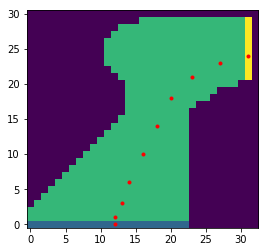

In [50]:
plt.imshow(env.track_as_np())
plt.gca().invert_yaxis()

trajectory = mc.generate_episode(mc.greedy_policy)
for t in trajectory:
    plt.plot(t.state2.x, t.state2.y, '.r')
    
rewards = map(lambda t: t.reward, trajectory)
print('return', sum(rewards))

return -8


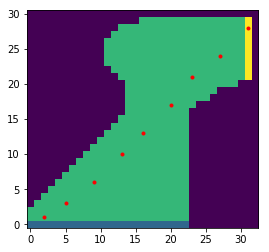

In [61]:
plt.imshow(env.track_as_np())
plt.gca().invert_yaxis()

trajectory = mc.generate_episode(mc.greedy_policy)
for t in trajectory:
    plt.plot(t.state2.x, t.state2.y, '.r')
    
rewards = map(lambda t: t.reward, trajectory)
print('return', sum(rewards))

return -9


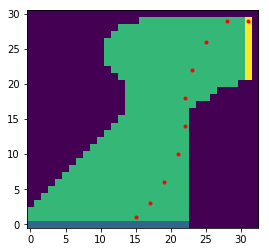

In [117]:
plt.imshow(env.track_as_np())
plt.gca().invert_yaxis()

trajectory = mc.generate_episode(mc.greedy_policy)
for t in trajectory:
    plt.plot(t.state2.x, t.state2.y, '.r')
    
rewards = map(lambda t: t.reward, trajectory)
print('return', sum(rewards))

Note that at the last position before the finish line the car tries to go off the track. The way the game rules are defined it does not get penalized as long as it crosses the finish line.

### Visualize optimal value function

In [ ]:
np.full_like

In [111]:
V_xy = np.full_like(env.track_as_np(), -np.inf,dtype=float)

Q_max = defaultdict(list)
for s, actions in mc._Q.items():
    Q_max[s.y, s.x].append(max(mc._Q[s].values()))
    
for pos, vals in Q_max.items():
    V_xy[pos] = np.mean(vals)
    

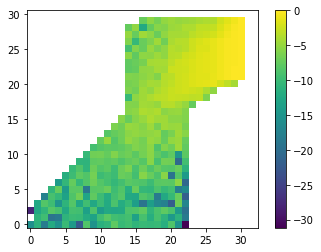

In [115]:
plt.imshow(V_xy)
plt.colorbar()
plt.gca().invert_yaxis()

### Check action-state coverage by Monte Carlo

In [63]:
# count all possible car positions
n_start_positions = (env._track == 'S').sum()
n_track_positions = (env._track == 'X').sum()
n_start_positions, n_track_positions

(23, 483)

In [78]:
# count all possible states, each state is car's position and speed
n_possible_states = n_start_positions * 3 + n_track_positions * (MAX_SPEED * MAX_SPEED - 1)
n_sampled_states = len(mc._Q)
print('n_possible_states = ', n_possible_states)
print('n_sampled_states = ', n_sampled_states)
print('n_sampled_states / n_possible_states = %d%%'
      % round(n_sampled_states/n_possible_states * 100))

n_possible_states =  7314
n_sampled_states =  5166
n_sampled_states / n_possible_states = 71%


In [80]:
n_possible_state_actions = n_possible_states * len(env.actions)
n_sampled_state_actions = sum(map(lambda v: len(v), mc._Q.values()))
print('n_possible_state_actions = ', n_possible_state_actions)
print('n_sampled_state_actions = ', n_sampled_state_actions)
print('n_sampled_state_actions / n_possible_state_actions = %d%%'
      % round(n_sampled_state_actions/n_possible_state_actions * 100))

n_possible_state_actions =  65826
n_sampled_state_actions =  21909
n_sampled_state_actions / n_possible_state_actions = 33%
